In [1]:
# Importar as bibliotecas necessárias
import os
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

# Verificar se CUDA está disponível e definir o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Definir as cores para as classes
CLASS_COLORS = { 
    'Doenca': (255, 0, 0), 
    'Saudavel': (0, 255, 0), 
    'Solo': (0, 0, 255),
    'Fundo': (0, 0, 0)
}

Usando o dispositivo: cuda


In [2]:
#definicao dos hiperparametros.
criterion = nn.CrossEntropyLoss()  # Considerando que temos múltiplas classes
# learning_rate = 0.001
num_epochs = 300
patience = 30
batch_size = 1

In [3]:
# Classe do Dataset personalizado
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Modificar a extensão da máscara para '.png'
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Carregar a imagem e a máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        
        if self.transform:
            # Aplicar transformações, se houver
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Convertemos as máscaras de imagem em um array de índices de classe
        mask = self.mask_to_class(mask)
        
        return image, mask
    
    def mask_to_class(self, mask):
        # Converte a máscara para um array NumPy e ajusta para escala de 0 a 255
        mask_array = (np.array(mask, dtype=np.float32) * 255).astype(np.uint8)

        # Garantir que esté em [H, W, C]
        if mask_array.shape[0] == 3:
            mask_array = mask_array.transpose(1, 2, 0)

        mask_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.int64)

        for i, color in enumerate(CLASS_COLORS.values()):
            # Realizar comparação e detecção de igualdade entre pixels
            equal_color = np.all(mask_array == color, axis=-1)
            mask_indices[equal_color] = i

        return torch.tensor(mask_indices, dtype=torch.long)

# Função para criar transformações de dados normais e de aumento de dados
def get_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256)),  # Redimensiona para uma dimensão adequada para o modelo
        transforms.ToTensor(),  # Normaliza para [0, 1]
    ])

# Outras inicializações de datasets e dataloaders
train_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base-no-aug/Train",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks-no-aug/Train",
    transform=get_transforms()
)

val_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base-no-aug/Val",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks-no-aug/Val",
    transform=get_transforms()
)

test_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base-no-aug/Test",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks-no-aug/Test",
    transform=get_transforms()
)
# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dados carregados e preparados.")

Dados carregados e preparados.


In [4]:
# Importar a biblioteca segmentation-models-pytorch
!pip install segmentation-models-pytorch --quiet

import segmentation_models_pytorch as smp

# Inicializar as arquiteturas dos modelos com os pesos pretreinados por padrão
unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
pspnet = smp.PSPNet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
linknet = smp.Linknet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
deeplabv3 = smp.DeepLabV3(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)

models = {
    'U-Net': unet,
    'PSPNet': pspnet,
    'LinkNet': linknet
}

print("Modelos configurados e prontos para treinamento.")

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modelos configurados e prontos para treinamento.


In [5]:
import torch
import torchmetrics
import numpy as np
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score, MulticlassPrecision

def compute_dice_coefficient(preds, targets):
    """
    Calcula o coeficiente de Dice
    """
    intersection = (preds * targets).sum()
    dice = (2. * intersection) / (preds.sum() + targets.sum())
    return dice.item()

def compute_aji(preds, targets):
    """
    Calcula o índice de Jaccard agregado (AJI)
    """
    preds = preds.detach().cpu().numpy().astype(np.bool_)
    targets = targets.detach().cpu().numpy().astype(np.bool_)
    
    # Calcula o Jaccard para cada componente individual nos targets/preds
    intersection = np.logical_and(preds, targets)
    union = np.logical_or(preds, targets)
    jaccard_per_class = intersection.sum() / (union.sum() + 1e-10)  # Evitar divisão por zero
    return jaccard_per_class

# Configurar as métricas, incluindo Dice e AJI personalizados
metrics = {
    'F1': MulticlassF1Score(num_classes=len(CLASS_COLORS)).to(device),
    'Jaccard': MulticlassJaccardIndex(num_classes=len(CLASS_COLORS)).to(device),
    'Precision': MulticlassPrecision(num_classes=len(CLASS_COLORS)).to(device),
    'Dice': compute_dice_coefficient,
    'AJI': compute_aji
}

In [6]:
def get_params_by_kind(model, n_base=7):
    base_vgg_bias = []
    base_vgg_weight = []
    core_weight = []
    core_bias = []

    for name, param in model.named_parameters():
        if 'vgg' in name and ('weight' in name or 'bias' in name):
            vgglayer = int(name.split('.')[-2])

            if vgglayer <= n_base:
                if 'bias' in name:
                    base_vgg_bias.append(param)
                else:
                    base_vgg_weight.append(param)
            else:
                if 'bias' in name:
                    core_bias.append(param)
                else:
                    core_weight.append(param)
        elif ('weight' in name or 'bias' in name):
            if 'bias' in name:
                core_bias.append(param)
            else:
                core_weight.append(param)

    return base_vgg_weight, base_vgg_bias, core_weight, core_bias

In [7]:
import csv
import time
import os
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Configuração do diretório para salvar os resultados
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data"
os.makedirs(results_dir, exist_ok=True)

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, metrics, num_epochs, device, patience, model_name, results_dir):
    since = time.time()
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience_counter = 0
    epochs_run = 0  # Variável para contar as épocas realizadas

    # Variáveis para armazenar tempos de execução
    training_time = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        epochs_run += 1  # Registrar a execução da época

        epoch_start = time.time()  # Marcar o início da época

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_metrics = {key: 0 for key in metrics.keys()}
            
            for inputs, masks in tqdm(data_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                for metric_name, metric in metrics.items():
                    if metric_name in ['Dice', 'AJI']:
                        value = metric(preds, masks)
                    else:  # Para métricas torchmetrics
                        value = metric(preds, masks).item()
                    running_metrics[metric_name] += value * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_metrics = {key: value / len(data_loader.dataset) for key, value in running_metrics.items()}

            print(f'{phase} Loss: {epoch_loss:.4f}')
            for metric_name in metrics:
                print(f'{phase} {metric_name}: {epoch_metrics[metric_name]:.4f}')

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        epoch_end = time.time()  # Marcar o fim da época
        epoch_time = epoch_end - epoch_start
        training_time += epoch_time  # Acumular tempos totais
        print(f'Epoch time: {epoch_time:.2f} seconds')

        print(f'Patience counter: {patience_counter}')

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')
    print(f'Total epochs run: {epochs_run}')

    # Restaurar o melhor modelo
    model.load_state_dict(best_model_wts)

    # Salvar o modelo treinado
    model_path = os.path.join(results_dir, f'{model_name}_best.pth')
    torch.save(model.state_dict(), model_path)

    # Coletar as métricas finais
    final_metrics = epoch_metrics
    final_metrics['best_loss'] = best_loss
    final_metrics['training_time'] = time_elapsed
    final_metrics['epochs_run'] = epochs_run

    # Salvar todas as métricas para CSV
    csv_path = os.path.join(results_dir, 'results.csv')
    write_metrics_to_csv(csv_path, model_name, final_metrics)

    return model

def write_metrics_to_csv(csv_path, model_name, metrics):
    headers = ['nome', 'f1-score', 'indice jaccard', 'precision', 'dice', 'aji', 'best_loss', 'training_time', 'epochs_run']
    row = [
        model_name,
        metrics['F1'],
        metrics['Jaccard'],
        metrics['Precision'],
        metrics['Dice'],
        metrics['AJI'],
        metrics['best_loss'],
        metrics['training_time'],
        metrics['epochs_run']
    ]

    file_exists = os.path.isfile(csv_path)

    with open(csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)  # Escrever cabeçalhos se o arquivo não existe
        writer.writerow(row)  # Salvar linha de métricas

# Executar o Treinamento dos Modelos
for model_name, model in models.items():
    print("*********************************************************************")
    print(f"Treinando {model_name} com early stopping.")
    
    # Defina os grupos de parâmetros para o modelo atual
    base_vgg_weight, base_vgg_bias, core_weight, core_bias = get_params_by_kind(model, 7)

    # Configurar o otimizador com diferentes learning rates para cada grupo de parâmetros
    optimizer = torch.optim.SGD([
        {'params': base_vgg_bias, 'lr': 0.00001},
        {'params': base_vgg_weight, 'lr': 0.00001},
        {'params': core_bias, 'lr': 0.02},
        {'params': core_weight, 'lr': 0.02, 'weight_decay': 0.0005}
    ], momentum=0.9)

    # Treinando o modelo
    trained_model = train_model_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        metrics=metrics,
        num_epochs=num_epochs,
        device=device,
        patience=patience,
        model_name=model_name,
        results_dir=results_dir
    )
    print(f'{model_name} treinado e salvo com sucesso.')

print("Treinamento completo de todos os modelos com early stopping.")

*********************************************************************
Treinando U-Net com early stopping.
Epoch 1/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


train Loss: 1.4060
train F1: 0.2639
train Jaccard: 0.1767
train Precision: 0.3357
train Dice: 1.6174
train AJI: 0.6854


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


val Loss: 5.2809
val F1: 0.2851
val Jaccard: 0.1870
val Precision: 0.3464
val Dice: 1.8422
val AJI: 0.7493
Epoch time: 7.73 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


train Loss: 1.1947
train F1: 0.3266
train Jaccard: 0.2416
train Precision: 0.4061
train Dice: 1.6330
train AJI: 0.6432


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


val Loss: 1.7221
val F1: 0.3118
val Jaccard: 0.2428
val Precision: 0.4573
val Dice: 1.3465
val AJI: 0.5097
Epoch time: 7.28 seconds
Patience counter: 0
Epoch 3/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


train Loss: 1.0483
train F1: 0.4123
train Jaccard: 0.3081
train Precision: 0.4600
train Dice: 1.7922
train AJI: 0.7130


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


val Loss: 1.1208
val F1: 0.3685
val Jaccard: 0.2853
val Precision: 0.4329
val Dice: 1.5571
val AJI: 0.5441
Epoch time: 7.45 seconds
Patience counter: 0
Epoch 4/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


train Loss: 0.9543
train F1: 0.4580
train Jaccard: 0.3557
train Precision: 0.5226
train Dice: 1.8613
train AJI: 0.7175


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


val Loss: 0.9102
val F1: 0.4256
val Jaccard: 0.3255
val Precision: 0.4967
val Dice: 1.7333
val AJI: 0.7129
Epoch time: 7.34 seconds
Patience counter: 0
Epoch 5/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


train Loss: 0.8648
train F1: 0.4698
train Jaccard: 0.3649
train Precision: 0.5131
train Dice: 1.8011
train AJI: 0.6618


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


val Loss: 1.0101
val F1: 0.4063
val Jaccard: 0.3229
val Precision: 0.4944
val Dice: 1.7024
val AJI: 0.7868
Epoch time: 7.33 seconds
Patience counter: 1
Epoch 6/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


train Loss: 0.7506
train F1: 0.5354
train Jaccard: 0.4266
train Precision: 0.5734
train Dice: 1.8710
train AJI: 0.7339


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


val Loss: 1.1056
val F1: 0.4393
val Jaccard: 0.3361
val Precision: 0.5466
val Dice: 1.5907
val AJI: 0.6876
Epoch time: 7.39 seconds
Patience counter: 2
Epoch 7/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


train Loss: 0.6709
train F1: 0.5853
train Jaccard: 0.4700
train Precision: 0.5994
train Dice: 1.9003
train AJI: 0.7557


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


val Loss: 0.9292
val F1: 0.4421
val Jaccard: 0.3360
val Precision: 0.5294
val Dice: 1.6419
val AJI: 0.6695
Epoch time: 7.31 seconds
Patience counter: 3
Epoch 8/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


train Loss: 0.5791
train F1: 0.6454
train Jaccard: 0.5261
train Precision: 0.6763
train Dice: 1.8947
train AJI: 0.7774


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


val Loss: 1.1805
val F1: 0.4710
val Jaccard: 0.3658
val Precision: 0.5393
val Dice: 1.6678
val AJI: 0.7371
Epoch time: 7.35 seconds
Patience counter: 4
Epoch 9/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


train Loss: 0.5396
train F1: 0.6676
train Jaccard: 0.5548
train Precision: 0.6879
train Dice: 1.9535
train AJI: 0.8039


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


val Loss: 1.0314
val F1: 0.4623
val Jaccard: 0.3579
val Precision: 0.5598
val Dice: 1.5715
val AJI: 0.6861
Epoch time: 7.37 seconds
Patience counter: 5
Epoch 10/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


train Loss: 0.5973
train F1: 0.6552
train Jaccard: 0.5365
train Precision: 0.6857
train Dice: 1.9082
train AJI: 0.7695


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


val Loss: 1.2239
val F1: 0.3799
val Jaccard: 0.3012
val Precision: 0.4376
val Dice: 1.4353
val AJI: 0.5144
Epoch time: 7.03 seconds
Patience counter: 6
Epoch 11/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


train Loss: 0.5627
train F1: 0.6885
train Jaccard: 0.5697
train Precision: 0.7304
train Dice: 1.9230
train AJI: 0.7992


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


val Loss: 1.0558
val F1: 0.4839
val Jaccard: 0.3734
val Precision: 0.5493
val Dice: 1.6788
val AJI: 0.7434
Epoch time: 7.23 seconds
Patience counter: 7
Epoch 12/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


train Loss: 0.4950
train F1: 0.7235
train Jaccard: 0.6071
train Precision: 0.7328
train Dice: 1.9502
train AJI: 0.8170


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


val Loss: 1.8271
val F1: 0.4450
val Jaccard: 0.3433
val Precision: 0.5673
val Dice: 1.4925
val AJI: 0.6432
Epoch time: 7.38 seconds
Patience counter: 8
Epoch 13/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


train Loss: 0.4870
train F1: 0.7241
train Jaccard: 0.6055
train Precision: 0.7419
train Dice: 1.9583
train AJI: 0.8148


100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


val Loss: 1.1272
val F1: 0.4520
val Jaccard: 0.3430
val Precision: 0.5432
val Dice: 1.5821
val AJI: 0.6685
Epoch time: 7.43 seconds
Patience counter: 9
Epoch 14/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


train Loss: 0.4517
train F1: 0.7273
train Jaccard: 0.6132
train Precision: 0.7478
train Dice: 1.9904
train AJI: 0.8316


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


val Loss: 1.4393
val F1: 0.4107
val Jaccard: 0.3180
val Precision: 0.5467
val Dice: 1.5731
val AJI: 0.6132
Epoch time: 7.42 seconds
Patience counter: 10
Epoch 15/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


train Loss: 0.4266
train F1: 0.7399
train Jaccard: 0.6295
train Precision: 0.7591
train Dice: 1.9886
train AJI: 0.8382


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


val Loss: 1.1018
val F1: 0.5055
val Jaccard: 0.3952
val Precision: 0.5708
val Dice: 1.6528
val AJI: 0.7296
Epoch time: 7.35 seconds
Patience counter: 11
Epoch 16/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


train Loss: 0.3837
train F1: 0.7619
train Jaccard: 0.6547
train Precision: 0.7676
train Dice: 2.0036
train AJI: 0.8515


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


val Loss: 1.0628
val F1: 0.4591
val Jaccard: 0.3575
val Precision: 0.5551
val Dice: 1.5631
val AJI: 0.6466
Epoch time: 7.37 seconds
Patience counter: 12
Epoch 17/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


train Loss: 0.3674
train F1: 0.7831
train Jaccard: 0.6776
train Precision: 0.8071
train Dice: 2.0050
train AJI: 0.8506


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


val Loss: 1.2436
val F1: 0.4697
val Jaccard: 0.3649
val Precision: 0.5547
val Dice: 1.5514
val AJI: 0.7105
Epoch time: 7.35 seconds
Patience counter: 13
Epoch 18/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


train Loss: 0.3165
train F1: 0.7955
train Jaccard: 0.6987
train Precision: 0.8159
train Dice: 2.0109
train AJI: 0.8702


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


val Loss: 1.2683
val F1: 0.4776
val Jaccard: 0.3710
val Precision: 0.5824
val Dice: 1.6276
val AJI: 0.6912
Epoch time: 7.31 seconds
Patience counter: 14
Epoch 19/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


train Loss: 0.2881
train F1: 0.8240
train Jaccard: 0.7311
train Precision: 0.8274
train Dice: 2.0473
train AJI: 0.8802


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


val Loss: 1.1079
val F1: 0.4779
val Jaccard: 0.3707
val Precision: 0.5519
val Dice: 1.5878
val AJI: 0.6992
Epoch time: 7.55 seconds
Patience counter: 15
Epoch 20/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


train Loss: 0.2679
train F1: 0.8421
train Jaccard: 0.7518
train Precision: 0.8587
train Dice: 2.0502
train AJI: 0.8869


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


val Loss: 1.2623
val F1: 0.4854
val Jaccard: 0.3768
val Precision: 0.5675
val Dice: 1.6008
val AJI: 0.7013
Epoch time: 7.49 seconds
Patience counter: 16
Epoch 21/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


train Loss: 0.2381
train F1: 0.8669
train Jaccard: 0.7807
train Precision: 0.8772
train Dice: 2.0662
train AJI: 0.8945


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


val Loss: 1.3637
val F1: 0.4938
val Jaccard: 0.3824
val Precision: 0.5581
val Dice: 1.5780
val AJI: 0.6988
Epoch time: 7.38 seconds
Patience counter: 17
Epoch 22/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


train Loss: 0.2153
train F1: 0.8772
train Jaccard: 0.7968
train Precision: 0.8901
train Dice: 2.0787
train AJI: 0.9041


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


val Loss: 1.1945
val F1: 0.4948
val Jaccard: 0.3841
val Precision: 0.5766
val Dice: 1.5873
val AJI: 0.6866
Epoch time: 7.32 seconds
Patience counter: 18
Epoch 23/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


train Loss: 0.2028
train F1: 0.8841
train Jaccard: 0.8062
train Precision: 0.8922
train Dice: 2.0878
train AJI: 0.9070


100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


val Loss: 1.3955
val F1: 0.5075
val Jaccard: 0.3963
val Precision: 0.5782
val Dice: 1.6499
val AJI: 0.7298
Epoch time: 7.51 seconds
Patience counter: 19
Epoch 24/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


train Loss: 0.1906
train F1: 0.8878
train Jaccard: 0.8124
train Precision: 0.9023
train Dice: 2.0890
train AJI: 0.9099


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


val Loss: 1.4939
val F1: 0.4886
val Jaccard: 0.3827
val Precision: 0.5625
val Dice: 1.6292
val AJI: 0.7287
Epoch time: 7.29 seconds
Patience counter: 20
Epoch 25/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


train Loss: 0.1782
train F1: 0.8964
train Jaccard: 0.8242
train Precision: 0.9004
train Dice: 2.1011
train AJI: 0.9160


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


val Loss: 1.4319
val F1: 0.4780
val Jaccard: 0.3701
val Precision: 0.5921
val Dice: 1.6152
val AJI: 0.6457
Epoch time: 7.37 seconds
Patience counter: 21
Epoch 26/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


train Loss: 0.1766
train F1: 0.8965
train Jaccard: 0.8252
train Precision: 0.9107
train Dice: 2.0986
train AJI: 0.9163


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


val Loss: 1.4375
val F1: 0.4946
val Jaccard: 0.3851
val Precision: 0.5640
val Dice: 1.6452
val AJI: 0.7191
Epoch time: 7.35 seconds
Patience counter: 22
Epoch 27/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


train Loss: 0.1699
train F1: 0.8875
train Jaccard: 0.8180
train Precision: 0.8969
train Dice: 2.1044
train AJI: 0.9168


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


val Loss: 1.4209
val F1: 0.5143
val Jaccard: 0.4008
val Precision: 0.5928
val Dice: 1.6445
val AJI: 0.7076
Epoch time: 7.36 seconds
Patience counter: 23
Epoch 28/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


train Loss: 0.1649
train F1: 0.8921
train Jaccard: 0.8238
train Precision: 0.8993
train Dice: 2.1084
train AJI: 0.9201


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


val Loss: 1.5221
val F1: 0.4872
val Jaccard: 0.3799
val Precision: 0.5625
val Dice: 1.6022
val AJI: 0.7066
Epoch time: 7.40 seconds
Patience counter: 24
Epoch 29/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


train Loss: 0.1521
train F1: 0.9091
train Jaccard: 0.8435
train Precision: 0.9192
train Dice: 2.1156
train AJI: 0.9243


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


val Loss: 1.3606
val F1: 0.5150
val Jaccard: 0.4029
val Precision: 0.5814
val Dice: 1.6570
val AJI: 0.7332
Epoch time: 7.82 seconds
Patience counter: 25
Epoch 30/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


train Loss: 0.1554
train F1: 0.9072
train Jaccard: 0.8405
train Precision: 0.9190
train Dice: 2.1175
train AJI: 0.9227


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


val Loss: 1.6104
val F1: 0.4856
val Jaccard: 0.3801
val Precision: 0.5603
val Dice: 1.6285
val AJI: 0.7313
Epoch time: 7.64 seconds
Patience counter: 26
Epoch 31/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


train Loss: 0.1614
train F1: 0.9028
train Jaccard: 0.8333
train Precision: 0.9110
train Dice: 2.1071
train AJI: 0.9196


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


val Loss: 1.5526
val F1: 0.5058
val Jaccard: 0.3913
val Precision: 0.5940
val Dice: 1.5999
val AJI: 0.6729
Epoch time: 7.37 seconds
Patience counter: 27
Epoch 32/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


train Loss: 0.1505
train F1: 0.9077
train Jaccard: 0.8407
train Precision: 0.9190
train Dice: 2.1164
train AJI: 0.9236


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


val Loss: 1.7598
val F1: 0.5050
val Jaccard: 0.3928
val Precision: 0.5746
val Dice: 1.5797
val AJI: 0.7057
Epoch time: 7.38 seconds
Patience counter: 28
Epoch 33/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


train Loss: 0.1437
train F1: 0.9142
train Jaccard: 0.8504
train Precision: 0.9222
train Dice: 2.1229
train AJI: 0.9277


100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


val Loss: 1.6256
val F1: 0.4966
val Jaccard: 0.3902
val Precision: 0.5704
val Dice: 1.6560
val AJI: 0.7391
Epoch time: 7.61 seconds
Patience counter: 29
Epoch 34/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


train Loss: 0.1338
train F1: 0.9188
train Jaccard: 0.8578
train Precision: 0.9248
train Dice: 2.1295
train AJI: 0.9316


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


val Loss: 1.6362
val F1: 0.4956
val Jaccard: 0.3890
val Precision: 0.5685
val Dice: 1.6428
val AJI: 0.7355
Epoch time: 7.32 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 4m 12s
Best val loss: 0.9102
Total epochs run: 34
U-Net treinado e salvo com sucesso.
*********************************************************************
Treinando PSPNet com early stopping.
Epoch 1/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


train Loss: 6.9872
train F1: 0.2593
train Jaccard: 0.1787
train Precision: 0.2943
train Dice: 1.5523
train AJI: 0.6245


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


val Loss: 100.9061
val F1: 0.2159
val Jaccard: 0.1508
val Precision: 0.2889
val Dice: 1.9873
val AJI: 0.7881
Epoch time: 6.89 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


train Loss: 5.5628
train F1: 0.3428
train Jaccard: 0.2418
train Precision: 0.4053
train Dice: 1.6058
train AJI: 0.6630


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


val Loss: 162.6593
val F1: 0.1535
val Jaccard: 0.0912
val Precision: 0.2151
val Dice: 1.7989
val AJI: 0.7882
Epoch time: 6.58 seconds
Patience counter: 1
Epoch 3/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


train Loss: 4.1967
train F1: 0.3047
train Jaccard: 0.2094
train Precision: 0.3872
train Dice: 1.5801
train AJI: 0.6371


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


val Loss: 5.2105
val F1: 0.3210
val Jaccard: 0.2313
val Precision: 0.3458
val Dice: 1.2597
val AJI: 0.4914
Epoch time: 6.79 seconds
Patience counter: 0
Epoch 4/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


train Loss: 2.3973
train F1: 0.3308
train Jaccard: 0.2319
train Precision: 0.3767
train Dice: 1.5318
train AJI: 0.6627


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


val Loss: 8.0939
val F1: 0.3051
val Jaccard: 0.2087
val Precision: 0.3955
val Dice: 1.7719
val AJI: 0.6590
Epoch time: 6.59 seconds
Patience counter: 1
Epoch 5/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


train Loss: 1.6445
train F1: 0.3903
train Jaccard: 0.2798
train Precision: 0.4765
train Dice: 1.7534
train AJI: 0.7090


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


val Loss: 10.2746
val F1: 0.3097
val Jaccard: 0.2295
val Precision: 0.3460
val Dice: 1.1342
val AJI: 0.3963
Epoch time: 6.80 seconds
Patience counter: 2
Epoch 6/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


train Loss: 1.3001
train F1: 0.4393
train Jaccard: 0.3315
train Precision: 0.4993
train Dice: 1.7260
train AJI: 0.6930


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


val Loss: 1.0239
val F1: 0.3856
val Jaccard: 0.2895
val Precision: 0.4651
val Dice: 1.5404
val AJI: 0.6565
Epoch time: 6.70 seconds
Patience counter: 0
Epoch 7/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


train Loss: 1.1886
train F1: 0.4829
train Jaccard: 0.3717
train Precision: 0.5469
train Dice: 1.7359
train AJI: 0.7377


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


val Loss: 1.0409
val F1: 0.3716
val Jaccard: 0.2863
val Precision: 0.4615
val Dice: 1.5750
val AJI: 0.5861
Epoch time: 6.70 seconds
Patience counter: 1
Epoch 8/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


train Loss: 1.0387
train F1: 0.5235
train Jaccard: 0.4072
train Precision: 0.5501
train Dice: 1.8427
train AJI: 0.7731


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


val Loss: 1.3750
val F1: 0.3419
val Jaccard: 0.2661
val Precision: 0.4298
val Dice: 1.4341
val AJI: 0.5379
Epoch time: 6.71 seconds
Patience counter: 2
Epoch 9/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


train Loss: 1.0162
train F1: 0.5607
train Jaccard: 0.4408
train Precision: 0.6114
train Dice: 1.8218
train AJI: 0.7756


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


val Loss: 1.4614
val F1: 0.3883
val Jaccard: 0.2909
val Precision: 0.5018
val Dice: 1.5478
val AJI: 0.6986
Epoch time: 6.67 seconds
Patience counter: 3
Epoch 10/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


train Loss: 1.1415
train F1: 0.4971
train Jaccard: 0.3842
train Precision: 0.5527
train Dice: 1.8107
train AJI: 0.7610


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


val Loss: 1.1117
val F1: 0.3792
val Jaccard: 0.2854
val Precision: 0.4671
val Dice: 1.5283
val AJI: 0.6338
Epoch time: 6.83 seconds
Patience counter: 4
Epoch 11/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


train Loss: 1.0227
train F1: 0.5409
train Jaccard: 0.4183
train Precision: 0.5867
train Dice: 1.8274
train AJI: 0.7739


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


val Loss: 1.2447
val F1: 0.4010
val Jaccard: 0.3001
val Precision: 0.5476
val Dice: 1.5946
val AJI: 0.6596
Epoch time: 6.64 seconds
Patience counter: 5
Epoch 12/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


train Loss: 0.8929
train F1: 0.5706
train Jaccard: 0.4473
train Precision: 0.6141
train Dice: 1.8495
train AJI: 0.7422


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


val Loss: 3.2579
val F1: 0.3736
val Jaccard: 0.2724
val Precision: 0.4752
val Dice: 1.7038
val AJI: 0.7196
Epoch time: 6.60 seconds
Patience counter: 6
Epoch 13/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


train Loss: 0.8223
train F1: 0.5717
train Jaccard: 0.4510
train Precision: 0.6104
train Dice: 1.8802
train AJI: 0.7785


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


val Loss: 1.5849
val F1: 0.3408
val Jaccard: 0.2634
val Precision: 0.4089
val Dice: 1.7051
val AJI: 0.6804
Epoch time: 6.80 seconds
Patience counter: 7
Epoch 14/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


train Loss: 0.9342
train F1: 0.5697
train Jaccard: 0.4454
train Precision: 0.6079
train Dice: 1.8658
train AJI: 0.7845


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


val Loss: 1.4298
val F1: 0.3943
val Jaccard: 0.3014
val Precision: 0.5168
val Dice: 1.5494
val AJI: 0.6628
Epoch time: 6.75 seconds
Patience counter: 8
Epoch 15/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


train Loss: 0.8873
train F1: 0.5959
train Jaccard: 0.4731
train Precision: 0.6296
train Dice: 1.8681
train AJI: 0.7779


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


val Loss: 1.4782
val F1: 0.3936
val Jaccard: 0.2993
val Precision: 0.4467
val Dice: 1.6704
val AJI: 0.6074
Epoch time: 6.90 seconds
Patience counter: 9
Epoch 16/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


train Loss: 0.8300
train F1: 0.6130
train Jaccard: 0.4853
train Precision: 0.6423
train Dice: 1.8782
train AJI: 0.7903


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


val Loss: 2.2785
val F1: 0.3872
val Jaccard: 0.2944
val Precision: 0.5023
val Dice: 1.7505
val AJI: 0.7373
Epoch time: 6.68 seconds
Patience counter: 10
Epoch 17/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


train Loss: 0.8010
train F1: 0.6009
train Jaccard: 0.4786
train Precision: 0.6443
train Dice: 1.8627
train AJI: 0.7770


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


val Loss: 1.5800
val F1: 0.4052
val Jaccard: 0.3148
val Precision: 0.4966
val Dice: 1.4315
val AJI: 0.5438
Epoch time: 6.73 seconds
Patience counter: 11
Epoch 18/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


train Loss: 0.7648
train F1: 0.6073
train Jaccard: 0.4844
train Precision: 0.6358
train Dice: 1.8963
train AJI: 0.7826


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


val Loss: 1.7569
val F1: 0.3636
val Jaccard: 0.2818
val Precision: 0.4211
val Dice: 1.6129
val AJI: 0.6192
Epoch time: 6.76 seconds
Patience counter: 12
Epoch 19/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


train Loss: 0.7622
train F1: 0.6395
train Jaccard: 0.5113
train Precision: 0.6755
train Dice: 1.9405
train AJI: 0.8164


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


val Loss: 2.3966
val F1: 0.3928
val Jaccard: 0.2973
val Precision: 0.4745
val Dice: 1.5720
val AJI: 0.6856
Epoch time: 6.74 seconds
Patience counter: 13
Epoch 20/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


train Loss: 0.7272
train F1: 0.6200
train Jaccard: 0.4974
train Precision: 0.6574
train Dice: 1.9028
train AJI: 0.7959


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


val Loss: 1.9426
val F1: 0.3793
val Jaccard: 0.2858
val Precision: 0.4802
val Dice: 1.5249
val AJI: 0.6101
Epoch time: 6.68 seconds
Patience counter: 14
Epoch 21/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


train Loss: 0.6871
train F1: 0.6824
train Jaccard: 0.5526
train Precision: 0.7193
train Dice: 1.9414
train AJI: 0.8088


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


val Loss: 1.5243
val F1: 0.4303
val Jaccard: 0.3283
val Precision: 0.5413
val Dice: 1.5933
val AJI: 0.6868
Epoch time: 6.72 seconds
Patience counter: 15
Epoch 22/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


train Loss: 0.6710
train F1: 0.6857
train Jaccard: 0.5599
train Precision: 0.7017
train Dice: 1.9456
train AJI: 0.8275


100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


val Loss: 1.7508
val F1: 0.4197
val Jaccard: 0.3223
val Precision: 0.5111
val Dice: 1.6613
val AJI: 0.7118
Epoch time: 6.65 seconds
Patience counter: 16
Epoch 23/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


train Loss: 0.6421
train F1: 0.6814
train Jaccard: 0.5561
train Precision: 0.7305
train Dice: 1.9402
train AJI: 0.8146


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


val Loss: 1.8639
val F1: 0.4097
val Jaccard: 0.3155
val Precision: 0.4736
val Dice: 1.7418
val AJI: 0.7482
Epoch time: 6.68 seconds
Patience counter: 17
Epoch 24/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


train Loss: 0.5418
train F1: 0.7051
train Jaccard: 0.5832
train Precision: 0.7217
train Dice: 1.9705
train AJI: 0.8365


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


val Loss: 1.5593
val F1: 0.4547
val Jaccard: 0.3448
val Precision: 0.5419
val Dice: 1.6432
val AJI: 0.7047
Epoch time: 6.68 seconds
Patience counter: 18
Epoch 25/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


train Loss: 0.4940
train F1: 0.7364
train Jaccard: 0.6156
train Precision: 0.7718
train Dice: 2.0039
train AJI: 0.8496


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


val Loss: 1.8596
val F1: 0.4367
val Jaccard: 0.3343
val Precision: 0.5436
val Dice: 1.6013
val AJI: 0.6890
Epoch time: 6.67 seconds
Patience counter: 19
Epoch 26/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


train Loss: 0.5416
train F1: 0.7435
train Jaccard: 0.6201
train Precision: 0.7632
train Dice: 1.9779
train AJI: 0.8448


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


val Loss: 1.7358
val F1: 0.3955
val Jaccard: 0.3094
val Precision: 0.5126
val Dice: 1.7529
val AJI: 0.7552
Epoch time: 6.78 seconds
Patience counter: 20
Epoch 27/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


train Loss: 0.5473
train F1: 0.7122
train Jaccard: 0.5901
train Precision: 0.7414
train Dice: 1.9609
train AJI: 0.8367


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


val Loss: 1.4166
val F1: 0.4067
val Jaccard: 0.3123
val Precision: 0.4897
val Dice: 1.7120
val AJI: 0.7765
Epoch time: 6.91 seconds
Patience counter: 21
Epoch 28/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


train Loss: 0.5775
train F1: 0.6951
train Jaccard: 0.5760
train Precision: 0.7149
train Dice: 1.9544
train AJI: 0.8192


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


val Loss: 1.9282
val F1: 0.4150
val Jaccard: 0.3094
val Precision: 0.5038
val Dice: 1.5727
val AJI: 0.6481
Epoch time: 6.63 seconds
Patience counter: 22
Epoch 29/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


train Loss: 0.5427
train F1: 0.7268
train Jaccard: 0.6053
train Precision: 0.7625
train Dice: 1.9928
train AJI: 0.8391


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


val Loss: 1.9172
val F1: 0.4304
val Jaccard: 0.3242
val Precision: 0.5833
val Dice: 1.5593
val AJI: 0.6504
Epoch time: 6.80 seconds
Patience counter: 23
Epoch 30/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


train Loss: 0.4726
train F1: 0.7598
train Jaccard: 0.6407
train Precision: 0.7694
train Dice: 2.0015
train AJI: 0.8557


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


val Loss: 1.9465
val F1: 0.4089
val Jaccard: 0.3155
val Precision: 0.5017
val Dice: 1.7180
val AJI: 0.7127
Epoch time: 6.75 seconds
Patience counter: 24
Epoch 31/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


train Loss: 0.4527
train F1: 0.7678
train Jaccard: 0.6534
train Precision: 0.7930
train Dice: 1.9933
train AJI: 0.8554


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


val Loss: 1.6817
val F1: 0.4464
val Jaccard: 0.3454
val Precision: 0.5581
val Dice: 1.7499
val AJI: 0.7884
Epoch time: 6.80 seconds
Patience counter: 25
Epoch 32/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


train Loss: 0.4608
train F1: 0.7561
train Jaccard: 0.6400
train Precision: 0.7865
train Dice: 2.0075
train AJI: 0.8553


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


val Loss: 2.3104
val F1: 0.4365
val Jaccard: 0.3381
val Precision: 0.5199
val Dice: 1.6149
val AJI: 0.6391
Epoch time: 6.78 seconds
Patience counter: 26
Epoch 33/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


train Loss: 0.4550
train F1: 0.7584
train Jaccard: 0.6438
train Precision: 0.7806
train Dice: 2.0004
train AJI: 0.8581


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


val Loss: 1.7135
val F1: 0.4366
val Jaccard: 0.3273
val Precision: 0.5135
val Dice: 1.7395
val AJI: 0.7444
Epoch time: 6.73 seconds
Patience counter: 27
Epoch 34/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


train Loss: 0.4350
train F1: 0.7652
train Jaccard: 0.6563
train Precision: 0.7952
train Dice: 2.0038
train AJI: 0.8633


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


val Loss: 2.1104
val F1: 0.4545
val Jaccard: 0.3457
val Precision: 0.5664
val Dice: 1.8087
val AJI: 0.7415
Epoch time: 6.78 seconds
Patience counter: 28
Epoch 35/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


train Loss: 0.4216
train F1: 0.7733
train Jaccard: 0.6643
train Precision: 0.8017
train Dice: 2.0194
train AJI: 0.8645


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


val Loss: 1.7004
val F1: 0.4737
val Jaccard: 0.3599
val Precision: 0.5434
val Dice: 1.6566
val AJI: 0.6934
Epoch time: 6.72 seconds
Patience counter: 29
Epoch 36/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


train Loss: 0.4242
train F1: 0.7680
train Jaccard: 0.6577
train Precision: 0.7859
train Dice: 2.0208
train AJI: 0.8608


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


val Loss: 2.1117
val F1: 0.4289
val Jaccard: 0.3287
val Precision: 0.5176
val Dice: 1.7734
val AJI: 0.7928
Epoch time: 6.69 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 4m 2s
Best val loss: 1.0239
Total epochs run: 36
PSPNet treinado e salvo com sucesso.
*********************************************************************
Treinando LinkNet com early stopping.
Epoch 1/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


train Loss: 1.4741
train F1: 0.2129
train Jaccard: 0.1344
train Precision: 0.2863
train Dice: 1.4210
train AJI: 0.6086


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


val Loss: 1.3103
val F1: 0.1997
val Jaccard: 0.1423
val Precision: 0.2554
val Dice: 1.7457
val AJI: 0.7881
Epoch time: 7.15 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


train Loss: 1.1868
train F1: 0.3356
train Jaccard: 0.2373
train Precision: 0.3851
train Dice: 1.6195
train AJI: 0.7100


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


val Loss: 0.9547
val F1: 0.3664
val Jaccard: 0.2685
val Precision: 0.4481
val Dice: 1.5562
val AJI: 0.6494
Epoch time: 7.30 seconds
Patience counter: 0
Epoch 3/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


train Loss: 1.0643
train F1: 0.3763
train Jaccard: 0.2740
train Precision: 0.4269
train Dice: 1.6748
train AJI: 0.7306


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


val Loss: 0.9556
val F1: 0.3611
val Jaccard: 0.2647
val Precision: 0.4666
val Dice: 1.5941
val AJI: 0.6871
Epoch time: 7.29 seconds
Patience counter: 1
Epoch 4/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


train Loss: 0.9923
train F1: 0.4601
train Jaccard: 0.3373
train Precision: 0.4975
train Dice: 1.7765
train AJI: 0.7578


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


val Loss: 0.9437
val F1: 0.4090
val Jaccard: 0.3070
val Precision: 0.4877
val Dice: 1.6494
val AJI: 0.7029
Epoch time: 7.31 seconds
Patience counter: 0
Epoch 5/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


train Loss: 0.9276
train F1: 0.4644
train Jaccard: 0.3443
train Precision: 0.5246
train Dice: 1.8063
train AJI: 0.7845


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


val Loss: 0.9065
val F1: 0.4363
val Jaccard: 0.3288
val Precision: 0.5184
val Dice: 1.7090
val AJI: 0.7674
Epoch time: 7.32 seconds
Patience counter: 0
Epoch 6/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


train Loss: 0.8570
train F1: 0.5607
train Jaccard: 0.4320
train Precision: 0.6067
train Dice: 1.9276
train AJI: 0.8085


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


val Loss: 0.9466
val F1: 0.4033
val Jaccard: 0.3107
val Precision: 0.4848
val Dice: 1.7177
val AJI: 0.7631
Epoch time: 7.23 seconds
Patience counter: 1
Epoch 7/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


train Loss: 0.7849
train F1: 0.5968
train Jaccard: 0.4667
train Precision: 0.6418
train Dice: 1.9515
train AJI: 0.8223


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


val Loss: 0.8952
val F1: 0.4281
val Jaccard: 0.3315
val Precision: 0.5137
val Dice: 1.7780
val AJI: 0.7827
Epoch time: 7.48 seconds
Patience counter: 0
Epoch 8/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


train Loss: 0.7037
train F1: 0.6458
train Jaccard: 0.5174
train Precision: 0.6764
train Dice: 1.9457
train AJI: 0.8440


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


val Loss: 1.0005
val F1: 0.4407
val Jaccard: 0.3398
val Precision: 0.5607
val Dice: 1.7533
val AJI: 0.7993
Epoch time: 7.50 seconds
Patience counter: 1
Epoch 9/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


train Loss: 0.6684
train F1: 0.6521
train Jaccard: 0.5269
train Precision: 0.6895
train Dice: 1.9800
train AJI: 0.8367


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


val Loss: 0.9436
val F1: 0.4476
val Jaccard: 0.3484
val Precision: 0.5251
val Dice: 1.7611
val AJI: 0.7961
Epoch time: 7.30 seconds
Patience counter: 2
Epoch 10/300
----------


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


train Loss: 0.6366
train F1: 0.6615
train Jaccard: 0.5367
train Precision: 0.6863
train Dice: 1.9670
train AJI: 0.8388


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


val Loss: 0.9899
val F1: 0.4163
val Jaccard: 0.3231
val Precision: 0.5141
val Dice: 1.8263
val AJI: 0.8002
Epoch time: 7.19 seconds
Patience counter: 3
Epoch 11/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


train Loss: 0.5510
train F1: 0.7086
train Jaccard: 0.5898
train Precision: 0.7346
train Dice: 1.9952
train AJI: 0.8539


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


val Loss: 0.9395
val F1: 0.4663
val Jaccard: 0.3658
val Precision: 0.5638
val Dice: 1.7875
val AJI: 0.8026
Epoch time: 7.29 seconds
Patience counter: 4
Epoch 12/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


train Loss: 0.5075
train F1: 0.7214
train Jaccard: 0.6048
train Precision: 0.7341
train Dice: 2.0045
train AJI: 0.8527


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


val Loss: 1.1249
val F1: 0.4184
val Jaccard: 0.3299
val Precision: 0.5286
val Dice: 1.7698
val AJI: 0.7904
Epoch time: 7.22 seconds
Patience counter: 5
Epoch 13/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


train Loss: 0.4645
train F1: 0.7343
train Jaccard: 0.6227
train Precision: 0.7493
train Dice: 2.0186
train AJI: 0.8588


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


val Loss: 0.9845
val F1: 0.4576
val Jaccard: 0.3602
val Precision: 0.5553
val Dice: 1.7845
val AJI: 0.7950
Epoch time: 7.28 seconds
Patience counter: 6
Epoch 14/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


train Loss: 0.4135
train F1: 0.7609
train Jaccard: 0.6549
train Precision: 0.7717
train Dice: 2.0347
train AJI: 0.8672


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


val Loss: 1.0299
val F1: 0.4157
val Jaccard: 0.3255
val Precision: 0.5324
val Dice: 1.8144
val AJI: 0.7888
Epoch time: 7.41 seconds
Patience counter: 7
Epoch 15/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


train Loss: 0.3867
train F1: 0.7644
train Jaccard: 0.6596
train Precision: 0.7685
train Dice: 2.0338
train AJI: 0.8670


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


val Loss: 1.0952
val F1: 0.4474
val Jaccard: 0.3521
val Precision: 0.5539
val Dice: 1.8009
val AJI: 0.7934
Epoch time: 7.27 seconds
Patience counter: 8
Epoch 16/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


train Loss: 0.3497
train F1: 0.7829
train Jaccard: 0.6843
train Precision: 0.7828
train Dice: 2.0429
train AJI: 0.8721


100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


val Loss: 1.0954
val F1: 0.4309
val Jaccard: 0.3451
val Precision: 0.5506
val Dice: 1.7929
val AJI: 0.7882
Epoch time: 7.28 seconds
Patience counter: 9
Epoch 17/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


train Loss: 0.3487
train F1: 0.7827
train Jaccard: 0.6843
train Precision: 0.7855
train Dice: 2.0494
train AJI: 0.8688


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


val Loss: 1.0089
val F1: 0.4896
val Jaccard: 0.3840
val Precision: 0.5622
val Dice: 1.7985
val AJI: 0.7913
Epoch time: 7.24 seconds
Patience counter: 10
Epoch 18/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


train Loss: 0.3265
train F1: 0.7889
train Jaccard: 0.6917
train Precision: 0.7933
train Dice: 2.0498
train AJI: 0.8758


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


val Loss: 1.1937
val F1: 0.4740
val Jaccard: 0.3661
val Precision: 0.5449
val Dice: 1.7460
val AJI: 0.7784
Epoch time: 7.28 seconds
Patience counter: 11
Epoch 19/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


train Loss: 0.2986
train F1: 0.8077
train Jaccard: 0.7158
train Precision: 0.8028
train Dice: 2.0619
train AJI: 0.8849


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


val Loss: 1.4600
val F1: 0.4473
val Jaccard: 0.3517
val Precision: 0.5431
val Dice: 1.7508
val AJI: 0.7867
Epoch time: 7.35 seconds
Patience counter: 12
Epoch 20/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


train Loss: 0.2711
train F1: 0.8239
train Jaccard: 0.7344
train Precision: 0.8253
train Dice: 2.0715
train AJI: 0.8885


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


val Loss: 1.1954
val F1: 0.4626
val Jaccard: 0.3620
val Precision: 0.5508
val Dice: 1.7643
val AJI: 0.7885
Epoch time: 7.30 seconds
Patience counter: 13
Epoch 21/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


train Loss: 0.2488
train F1: 0.8411
train Jaccard: 0.7569
train Precision: 0.8356
train Dice: 2.0706
train AJI: 0.8946


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


val Loss: 1.3933
val F1: 0.4829
val Jaccard: 0.3712
val Precision: 0.5494
val Dice: 1.7306
val AJI: 0.7712
Epoch time: 7.30 seconds
Patience counter: 14
Epoch 22/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


train Loss: 0.2298
train F1: 0.8437
train Jaccard: 0.7617
train Precision: 0.8419
train Dice: 2.0857
train AJI: 0.8992


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


val Loss: 1.4004
val F1: 0.4569
val Jaccard: 0.3578
val Precision: 0.5437
val Dice: 1.7443
val AJI: 0.7794
Epoch time: 7.31 seconds
Patience counter: 15
Epoch 23/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


train Loss: 0.2165
train F1: 0.8522
train Jaccard: 0.7733
train Precision: 0.8503
train Dice: 2.0912
train AJI: 0.9034


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


val Loss: 1.2486
val F1: 0.4660
val Jaccard: 0.3652
val Precision: 0.5529
val Dice: 1.8006
val AJI: 0.7845
Epoch time: 7.25 seconds
Patience counter: 16
Epoch 24/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


train Loss: 0.2059
train F1: 0.8604
train Jaccard: 0.7855
train Precision: 0.8562
train Dice: 2.0907
train AJI: 0.9072


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


val Loss: 1.6124
val F1: 0.4842
val Jaccard: 0.3754
val Precision: 0.5526
val Dice: 1.6962
val AJI: 0.7724
Epoch time: 7.34 seconds
Patience counter: 17
Epoch 25/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


train Loss: 0.1939
train F1: 0.8726
train Jaccard: 0.7969
train Precision: 0.8721
train Dice: 2.1039
train AJI: 0.9091


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


val Loss: 1.5030
val F1: 0.4675
val Jaccard: 0.3606
val Precision: 0.5439
val Dice: 1.7381
val AJI: 0.7766
Epoch time: 7.26 seconds
Patience counter: 18
Epoch 26/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


train Loss: 0.1873
train F1: 0.8676
train Jaccard: 0.7950
train Precision: 0.8637
train Dice: 2.0981
train AJI: 0.9115


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


val Loss: 1.3040
val F1: 0.5081
val Jaccard: 0.3921
val Precision: 0.5606
val Dice: 1.7199
val AJI: 0.7589
Epoch time: 7.35 seconds
Patience counter: 19
Epoch 27/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


train Loss: 0.1936
train F1: 0.8747
train Jaccard: 0.7993
train Precision: 0.8722
train Dice: 2.1036
train AJI: 0.9096


100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


val Loss: 1.3652
val F1: 0.4670
val Jaccard: 0.3626
val Precision: 0.5416
val Dice: 1.7674
val AJI: 0.7726
Epoch time: 7.31 seconds
Patience counter: 20
Epoch 28/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


train Loss: 0.1871
train F1: 0.8790
train Jaccard: 0.8055
train Precision: 0.8774
train Dice: 2.1095
train AJI: 0.9122


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


val Loss: 1.6003
val F1: 0.4776
val Jaccard: 0.3707
val Precision: 0.5477
val Dice: 1.7368
val AJI: 0.7761
Epoch time: 7.30 seconds
Patience counter: 21
Epoch 29/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


train Loss: 0.1809
train F1: 0.8604
train Jaccard: 0.7904
train Precision: 0.8570
train Dice: 2.1079
train AJI: 0.9149


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


val Loss: 1.7575
val F1: 0.4803
val Jaccard: 0.3725
val Precision: 0.5449
val Dice: 1.7125
val AJI: 0.7730
Epoch time: 7.26 seconds
Patience counter: 22
Epoch 30/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


train Loss: 0.1698
train F1: 0.8758
train Jaccard: 0.8070
train Precision: 0.8747
train Dice: 2.1167
train AJI: 0.9188


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


val Loss: 1.8560
val F1: 0.4737
val Jaccard: 0.3663
val Precision: 0.5402
val Dice: 1.6989
val AJI: 0.7700
Epoch time: 7.22 seconds
Patience counter: 23
Epoch 31/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


train Loss: 0.1590
train F1: 0.8952
train Jaccard: 0.8297
train Precision: 0.8929
train Dice: 2.1229
train AJI: 0.9242


100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


val Loss: 1.7656
val F1: 0.4774
val Jaccard: 0.3665
val Precision: 0.5400
val Dice: 1.7003
val AJI: 0.7649
Epoch time: 7.44 seconds
Patience counter: 24
Epoch 32/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


train Loss: 0.1483
train F1: 0.9011
train Jaccard: 0.8385
train Precision: 0.9001
train Dice: 2.1281
train AJI: 0.9281


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


val Loss: 1.7523
val F1: 0.4800
val Jaccard: 0.3678
val Precision: 0.5394
val Dice: 1.6864
val AJI: 0.7609
Epoch time: 7.39 seconds
Patience counter: 25
Epoch 33/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


train Loss: 0.1402
train F1: 0.9064
train Jaccard: 0.8462
train Precision: 0.9048
train Dice: 2.1348
train AJI: 0.9319


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


val Loss: 1.6763
val F1: 0.4896
val Jaccard: 0.3768
val Precision: 0.5432
val Dice: 1.7015
val AJI: 0.7611
Epoch time: 7.26 seconds
Patience counter: 26
Epoch 34/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


train Loss: 0.1336
train F1: 0.9100
train Jaccard: 0.8521
train Precision: 0.9098
train Dice: 2.1385
train AJI: 0.9348


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


val Loss: 1.7248
val F1: 0.4776
val Jaccard: 0.3671
val Precision: 0.5370
val Dice: 1.7061
val AJI: 0.7622
Epoch time: 7.26 seconds
Patience counter: 27
Epoch 35/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


train Loss: 0.1297
train F1: 0.9004
train Jaccard: 0.8445
train Precision: 0.9004
train Dice: 2.1419
train AJI: 0.9365


100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


val Loss: 2.0060
val F1: 0.4782
val Jaccard: 0.3655
val Precision: 0.5350
val Dice: 1.6844
val AJI: 0.7592
Epoch time: 7.25 seconds
Patience counter: 28
Epoch 36/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


train Loss: 0.1302
train F1: 0.9229
train Jaccard: 0.8650
train Precision: 0.9230
train Dice: 2.1406
train AJI: 0.9359


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


val Loss: 1.5745
val F1: 0.4885
val Jaccard: 0.3766
val Precision: 0.5477
val Dice: 1.7309
val AJI: 0.7583
Epoch time: 7.25 seconds
Patience counter: 29
Epoch 37/300
----------


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


train Loss: 0.1268
train F1: 0.9135
train Jaccard: 0.8573
train Precision: 0.9133
train Dice: 2.1440
train AJI: 0.9369


100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

val Loss: 1.8342
val F1: 0.4822
val Jaccard: 0.3714
val Precision: 0.5436
val Dice: 1.7171
val AJI: 0.7615
Epoch time: 7.24 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 4m 30s
Best val loss: 0.8952
Total epochs run: 37
LinkNet treinado e salvo com sucesso.
Treinamento completo de todos os modelos com early stopping.


Visualizando e salvando predições para U-Net...


C:\Users\Henrique Moreira\AppData\Local\Temp\ipykernel_10560\2253927742.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(trained

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


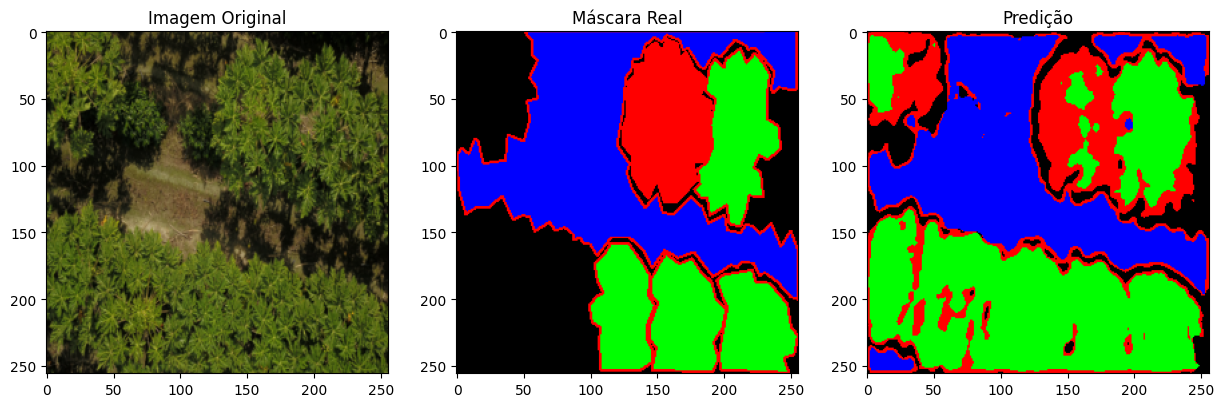

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


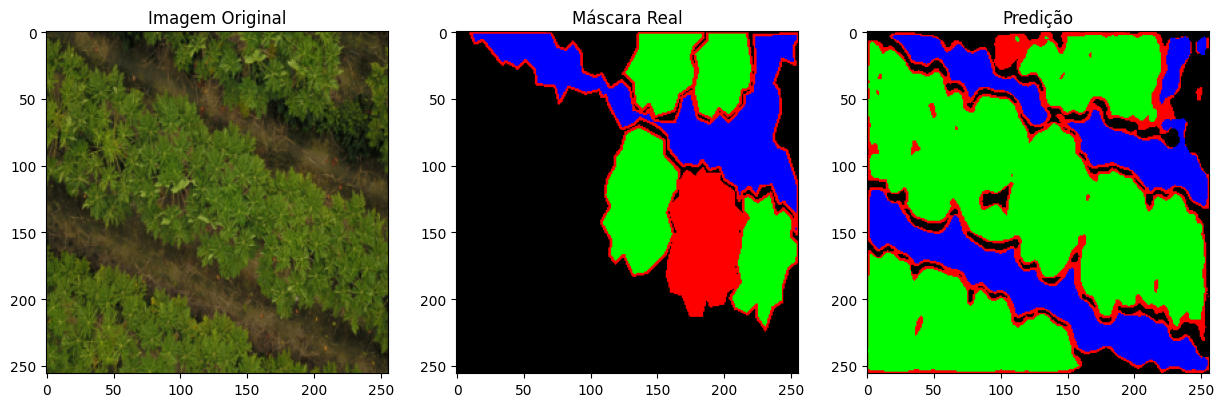

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


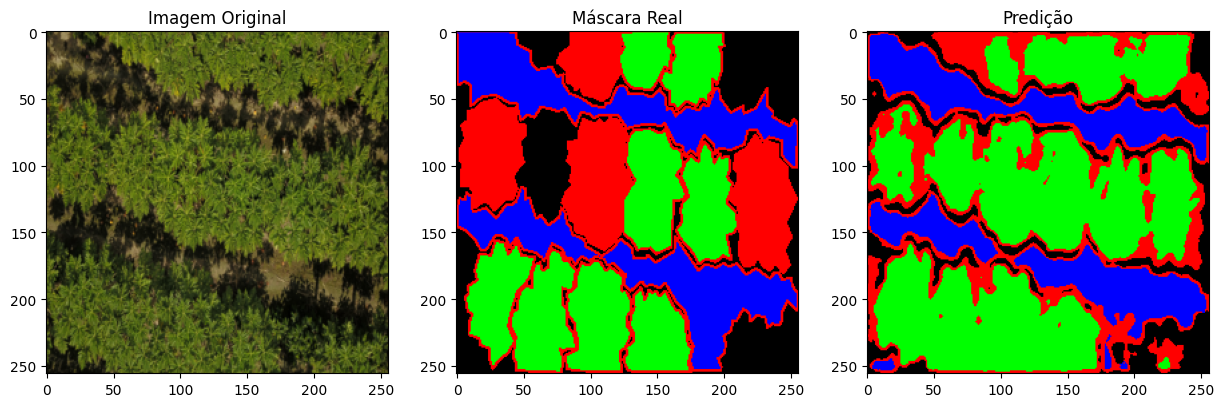

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


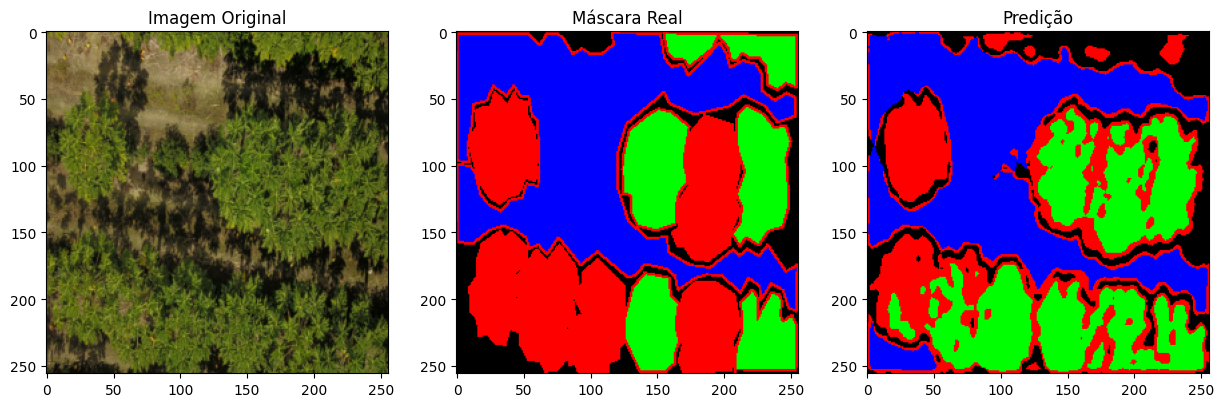

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


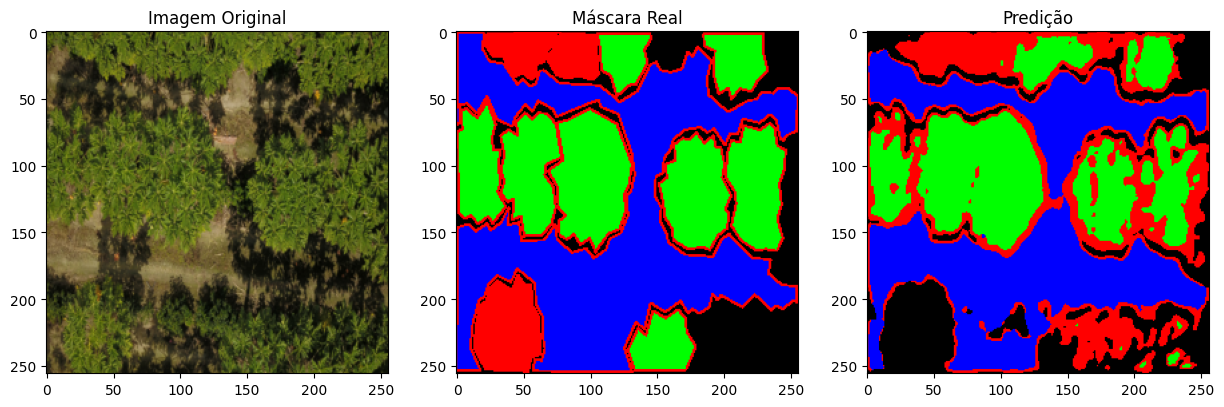

Visualizando e salvando predições para PSPNet...
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


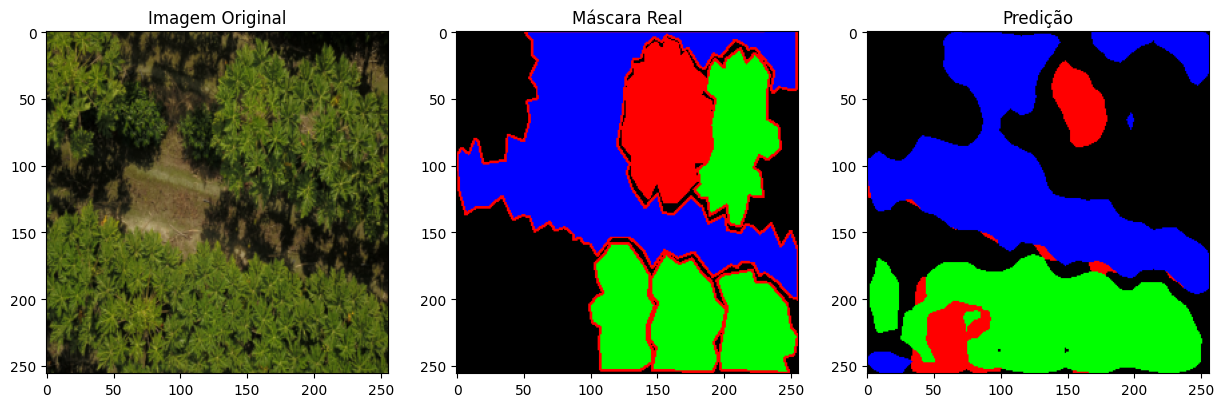

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


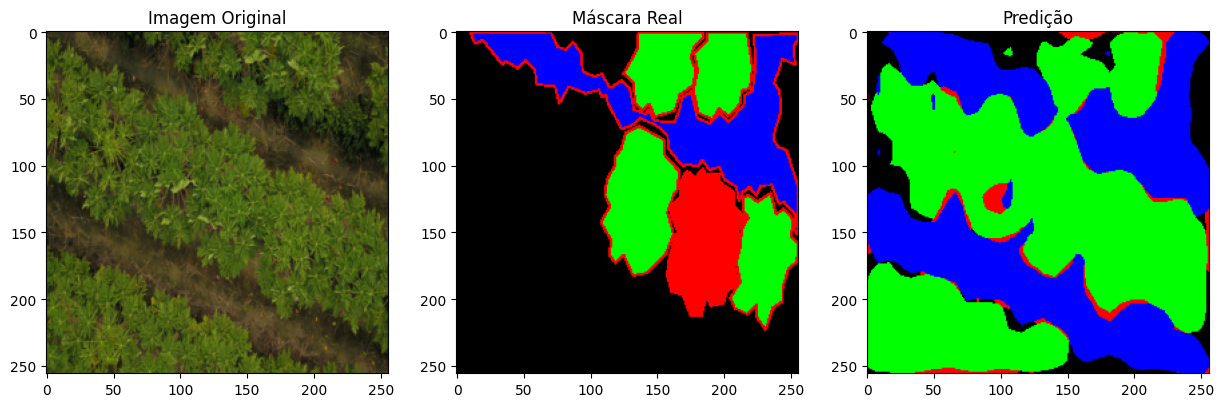

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


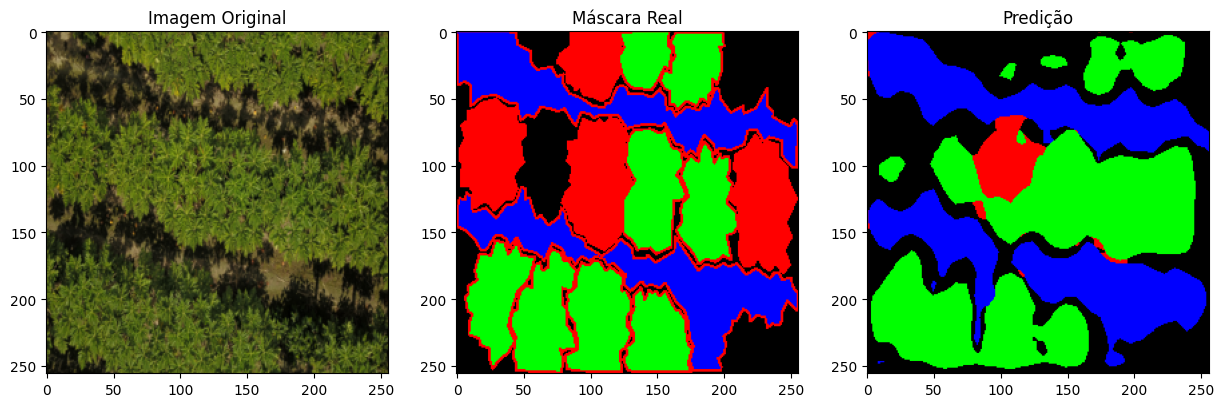

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


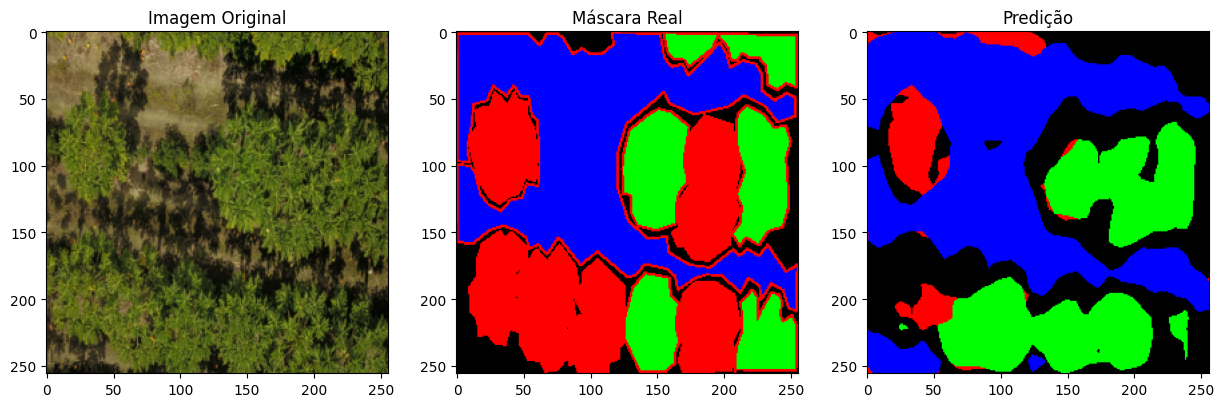

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


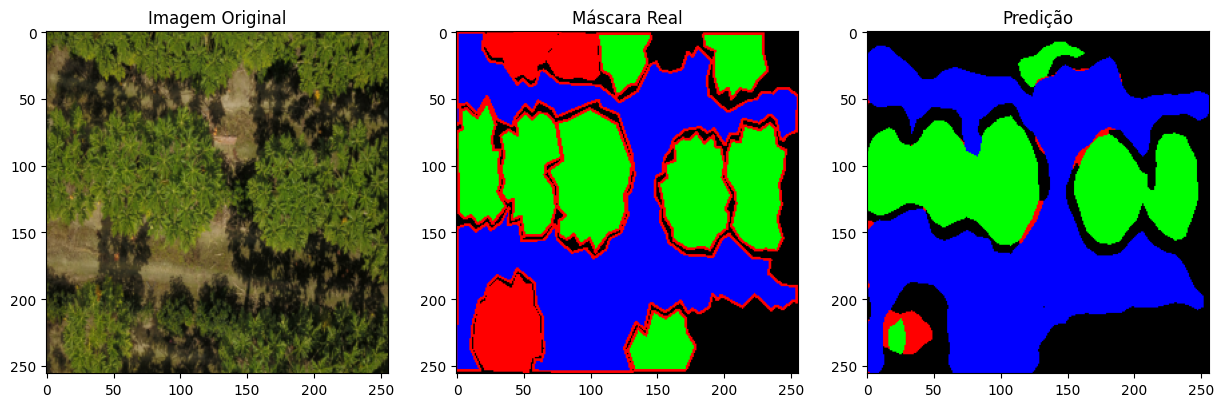

Visualizando e salvando predições para LinkNet...
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


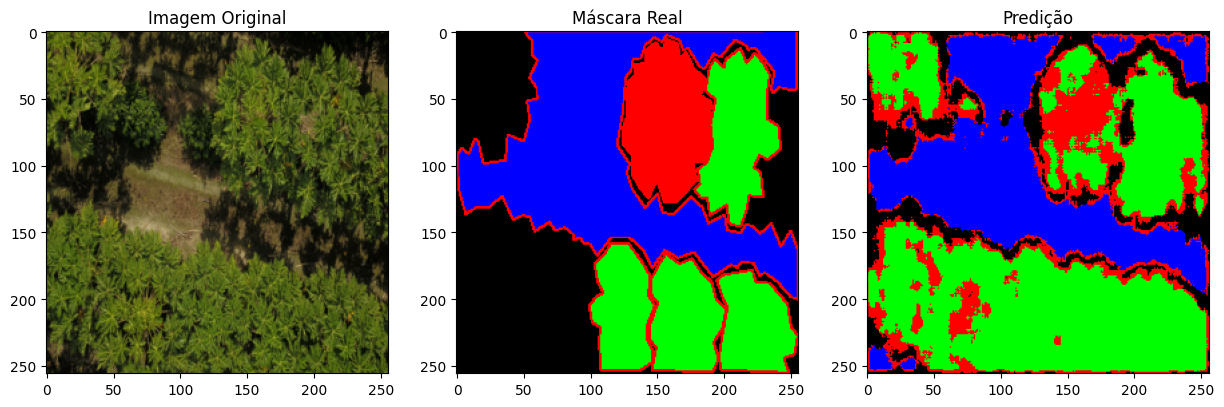

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


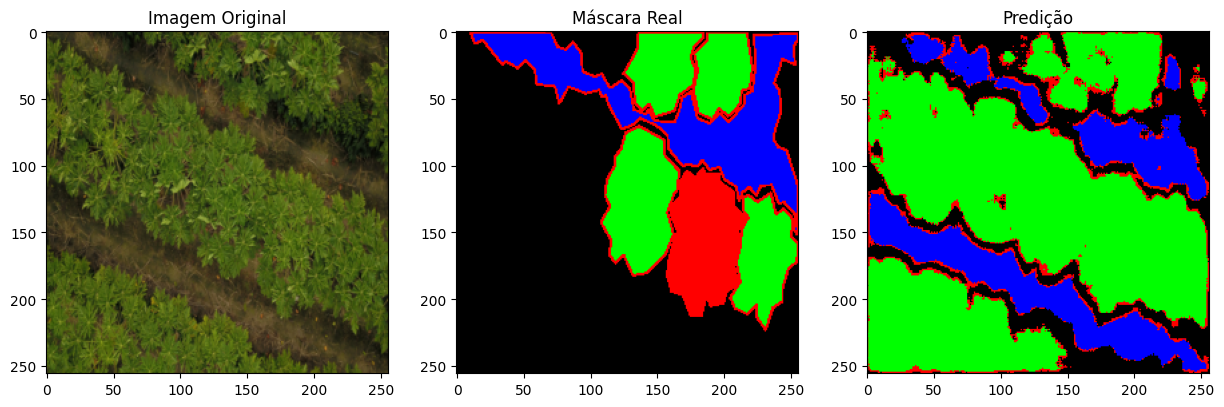

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


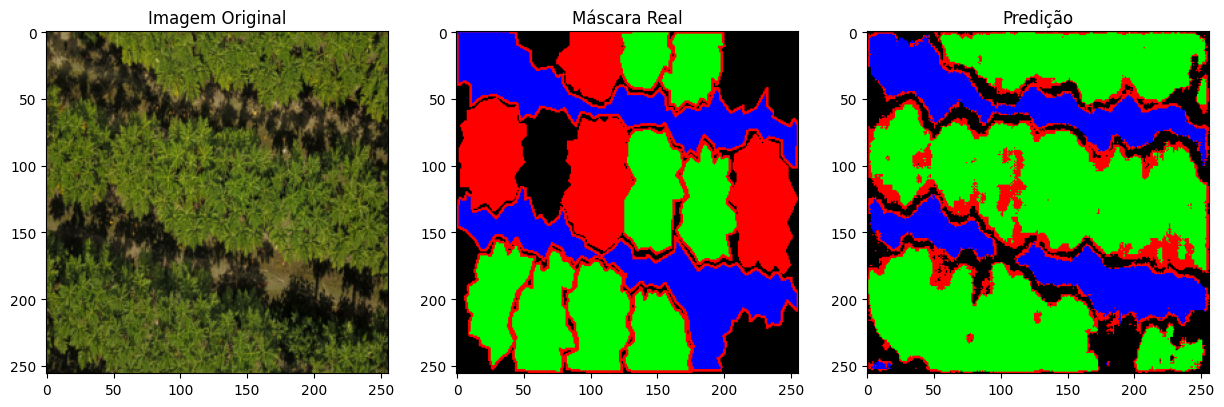

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


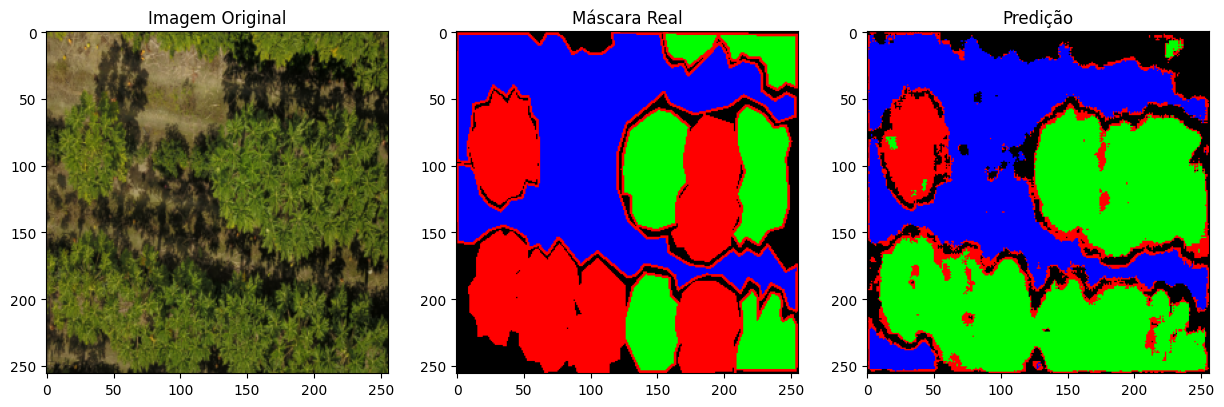

Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Unique classes in mask: [0 1 2 3]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Mapping class 3 to color (0, 0, 0)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


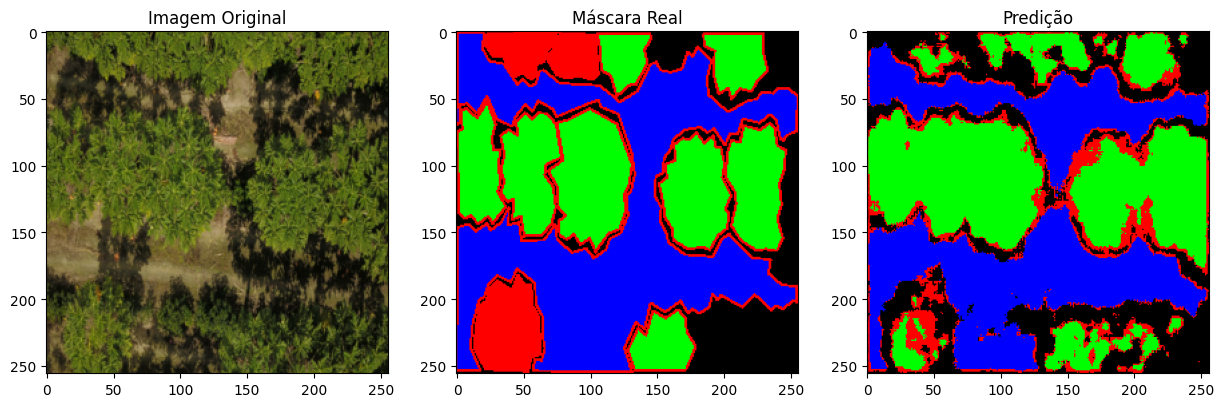

Visualização e salvamento concluídos!


In [11]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Diretório para salvar os resultados das imagens
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/images"
os.makedirs(results_dir, exist_ok=True)

# Diretório onde os arquivos do modelo foram salvados
model_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data" 

# Função auxiliar para transformar índices de classe em cores RGB
def class_to_rgb(mask_indices):
    mask_rgb = np.zeros((mask_indices.shape[0], mask_indices.shape[1], 3), dtype=np.uint8)
    unique_classes = np.unique(mask_indices)
    print(f"Unique classes in mask: {unique_classes}")  # Log para classes únicas

    for class_index, color in enumerate(CLASS_COLORS.values()):
        mask_rgb[mask_indices == class_index] = color
        print(f"Mapping class {class_index} to color {color}")  # Log para mapeamento
    return mask_rgb

# Função para visualizar e salvar predições
def visualize_and_save_predictions(model, data_loader, device, results_dir, model_name, num_images=5):
    model.eval()
    images_saved = 0

    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                images_saved += 1
                if images_saved > num_images:
                    return
                
                # Processamento para visualização
                image = (inputs[i].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                
                # Conversão de índices para RGB
                mask = class_to_rgb(masks[i].cpu().numpy())
                prediction = class_to_rgb(preds[i].cpu().numpy())

                # Logs para depuração
                print(f"Input shape: {inputs[i].shape}")
                print(f"Mask shape: {masks[i].shape}")
                print(f"Prediction shape: {preds[i].shape}")

                # Visualização
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Imagem Original')

                plt.subplot(1, 3, 2)
                plt.imshow(mask)
                plt.title('Máscara Real')

                plt.subplot(1, 3, 3)
                plt.imshow(prediction)
                plt.title('Predição')

                plt.show()
                
                # Salvar as imagens
                plt.imsave(os.path.join(results_dir, f'{model_name}_input_{images_saved}.png'), image)
                plt.imsave(os.path.join(results_dir, f'{model_name}_mask_{images_saved}.png'), mask)
                plt.imsave(os.path.join(results_dir, f'{model_name}_prediction_{images_saved}.png'), prediction)

# Executar para cada modelo
for model_name, model in models.items():
    print(f"Visualizando e salvando predições para {model_name}...")
    
    trained_model = model
    trained_model_path = os.path.join(model_dir, f'{model_name}_best.pth')
    trained_model.load_state_dict(torch.load(trained_model_path))
    trained_model.to(device)
    
    visualize_and_save_predictions(trained_model, test_loader, device, results_dir, model_name, num_images=5)

print("Visualização e salvamento concluídos!")